# 02 - Feature Engineering (Spark-First, Big-Data Style)

**Goal:** Build **Spark-native** features for price elasticity modeling and dynamic pricing optimization across European short-term rental markets.

## Dataset Structure

This dataset uses a **seasonal cross-sectional** design rather than time-series:
- **No booking dates/timestamps** — instead, listings are expanded across contextual segments
- **Segments defined by:** `city × season × weekend` (10 cities × 3 seasons × 2 day-types = 60 segments)
- **Season categories:** `high` (peak tourism), `shoulder` (moderate demand), `low` (off-season)
- **Weekend flag:** Binary indicator (Friday-Sunday = 1, Monday-Thursday = 0)
- **Days in period & days booked:** Represent typical demand patterns for each segment

This structure allows **elasticity analysis across demand contexts** (e.g., inelastic behavior on high-season weekends vs. elastic behavior on low-season weekdays) without requiring longitudinal data

## Outputs

- **`data/processed/listing_features.parquet`** — Listing-level engineered features (all segments)
- **`data/processed/segment_demand_dataset.parquet`** — Aggregated elasticity curves and optimization parameters (60 segments)
- **`outputs/feature_preview.csv`** — Small bounded sample for inspection (optional)


In [ ]:
%load_ext autoreload
%autoreload 2

In [40]:
import os, sys
from pathlib import Path

# Locate project root (folder containing 'src')
project_root = Path.cwd()
for p in [project_root] + list(project_root.parents):
    if (p / 'src').exists():
        project_root = p
        break
if not (project_root / 'src').exists():
    raise FileNotFoundError("Could not find 'src' directory.")

# Windows Spark/Hadoop helpers (assumes hadoop binaries already exist from Notebook 01)
hadoop_home = project_root / 'hadoop'
bin_dir = hadoop_home / 'bin'
os.environ['HADOOP_HOME'] = str(hadoop_home)
os.environ['hadoop.home.dir'] = str(hadoop_home)
os.environ['PATH'] = str(bin_dir) + os.pathsep + os.environ.get('PATH', '')

sys.path.insert(0, str(project_root))

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = (
    SparkSession.builder
    .appName('airbnb-feature-engineering')
    .master('local[*]')
    .getOrCreate()
)

print('Spark version:', spark.version)

Spark version: 3.5.0


In [41]:
# Persist datasets (Spark writes)
out_processed = project_root / 'data' / 'processed'
out_processed.mkdir(parents=True, exist_ok=True)
outputs_dir = project_root / 'outputs'
outputs_dir.mkdir(parents=True, exist_ok=True)

In [42]:
from src.data_processing.feature_engineering import SparkFeatureEngineer

# Load raw parquet (no encoding yet)
df = spark.read.parquet(str(project_root / "data" / "processed" / "consolidated.parquet"))

print('Rows:', f"{df.count():,}")
print('Columns:', len(df.columns))
df.printSchema()

# Show a schema-aware sample (works for both old and new dataset schemas)
sample_cols = [c for c in ['city', 'weekend', 'day_type', 'room_type', 'listing_price', 'person_capacity', 'city_center_dist', 'metro_dist'] if c in df.columns]
df.select(*sample_cols).show(10, truncate=False)

Rows: 310,242
Columns: 18
root
 |-- listing_price: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- person_capacity: double (nullable = true)
 |-- host_is_superhost: integer (nullable = true)
 |-- multi: integer (nullable = true)
 |-- biz: integer (nullable = true)
 |-- cleanliness_rating: double (nullable = true)
 |-- guest_satisfaction_overall: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- city_center_dist: double (nullable = true)
 |-- metro_dist: double (nullable = true)
 |-- city: string (nullable = true)
 |-- listing_id: integer (nullable = true)
 |-- season: string (nullable = true)
 |-- weekend: integer (nullable = true)
 |-- days_in_period: double (nullable = true)
 |-- days_booked: double (nullable = true)
 |-- occupancy_rate: double (nullable = true)

+----+-------+------------+------------------+---------------+------------------+------------------+
|city|weekend|room_type   |listing_price     |person_capacity|city_center_dist  

In [44]:
# Sanity checks: Clip numeric values to logical ranges
from pyspark.sql import functions as F

# Define logical bounds for each numeric column
df = df.withColumn('listing_price', 
    F.when(F.col('listing_price') < 10, 10)
     .when(F.col('listing_price') > 10000, 10000)
     .otherwise(F.col('listing_price'))
)

df = df.withColumn('person_capacity', 
    F.when(F.col('person_capacity') < 1, 1)
     .when(F.col('person_capacity') > 20, 20)
     .otherwise(F.col('person_capacity'))
)

df = df.withColumn('bedrooms', 
    F.when(F.col('bedrooms') < 0, 0)
     .when(F.col('bedrooms') > 15, 15)
     .otherwise(F.col('bedrooms'))
)

df = df.withColumn('cleanliness_rating', 
    F.when(F.col('cleanliness_rating') < 0, 0)
     .when(F.col('cleanliness_rating') > 10, 10)
     .otherwise(F.col('cleanliness_rating'))
)

df = df.withColumn('guest_satisfaction_overall', 
    F.when(F.col('guest_satisfaction_overall') < 0, 0)
     .when(F.col('guest_satisfaction_overall') > 100, 100)
     .otherwise(F.col('guest_satisfaction_overall'))
)

df = df.withColumn('city_center_dist', 
    F.when(F.col('city_center_dist') < 0, 0)
     .when(F.col('city_center_dist') > 50, 50)
     .otherwise(F.col('city_center_dist'))
)

df = df.withColumn('metro_dist', 
    F.when(F.col('metro_dist') < 0, 0)
     .when(F.col('metro_dist') > 50, 50)
     .otherwise(F.col('metro_dist'))
)

df = df.withColumn('days_in_period', 
    F.when(F.col('days_in_period') < 0, 0)
     .when(F.col('days_in_period') > 365, 365)
     .otherwise(F.col('days_in_period'))
)

df = df.withColumn('days_booked', 
    F.when(F.col('days_booked') < 0, 0)
     .when(F.col('days_booked') > F.col('days_in_period'), F.col('days_in_period'))
     .otherwise(F.col('days_booked'))
)

df = df.withColumn('occupancy_rate', 
    F.when(F.col('occupancy_rate') < 0, 0)
     .when(F.col('occupancy_rate') > 1, 1)
     .otherwise(F.col('occupancy_rate'))
)

# Clip binary columns to 0 or 1
for binary_col in ['host_is_superhost', 'multi', 'biz', 'weekend']:
    df = df.withColumn(binary_col,
        F.when(F.col(binary_col) < 0, 0)
         .when(F.col(binary_col) > 1, 1)
         .otherwise(F.col(binary_col))
    )



In [45]:
# Feature Engineering Spark pipeline: encode → engineer → segment

listing_features_df, segment_df = SparkFeatureEngineer.build_feature_dataset(
    df, 
    segment_cols=['city', 'weekend', 'season'],
    encode_categoricals=True
)

In [46]:
listing_features_df.columns

['city',
 'weekend',
 'season',
 'listing_price',
 'person_capacity',
 'host_is_superhost',
 'multi',
 'biz',
 'cleanliness_rating',
 'guest_satisfaction_overall',
 'bedrooms',
 'city_center_dist',
 'metro_dist',
 'listing_id',
 'days_in_period',
 'days_booked',
 'occupancy_rate',
 'log_price',
 'price_per_person',
 'price_per_bedroom',
 'capacity_bin',
 'quality_score',
 'price_x_satisfaction',
 'price_per_dist_km',
 'log_metro_dist',
 'is_weekend',
 'cat_room_type_entire_home_apt',
 'cat_room_type_private_room',
 'cat_room_type_shared_room',
 'cat_city_amsterdam',
 'cat_city_athens',
 'cat_city_barcelona',
 'cat_city_berlin',
 'cat_city_budapest',
 'cat_city_lisbon',
 'cat_city_london',
 'cat_city_paris',
 'cat_city_rome',
 'cat_city_vienna',
 'cat_season_high',
 'cat_season_low',
 'cat_season_shoulder',
 'cat_capacity_bin_2',
 'cat_capacity_bin_3',
 'cat_capacity_bin_4',
 'cat_capacity_bin_5',
 'segment_listing_count',
 'segment_avg_price',
 'segment_median_price',
 'segment_p90_pri

In [48]:
# Remove outliers using IQR method per city and weekend group

# Ensure 'city' and 'weekend' exist (reverse one-hot if needed)
city_cols = [c for c in listing_features_df.columns if c.startswith('cat_city_')]
if 'city' not in listing_features_df.columns and city_cols:
    city_case_expr = F.coalesce(
        *[F.when(F.col(col) == 1, F.lit(col.replace('cat_city_', ''))).otherwise(None) for col in city_cols]
    )
    listing_features_df = listing_features_df.withColumn('city', city_case_expr)

if 'weekend' not in listing_features_df.columns and 'is_weekend' in listing_features_df.columns:
    listing_features_df = listing_features_df.withColumn('weekend', F.col('is_weekend').cast('int'))

# Calculate Q1, Q3 per city and weekend
group_stats = listing_features_df.groupBy('city', 'weekend', 'season').agg(
    F.expr('percentile_approx(price_per_bedroom, 0.25)').alias('Q1'),
    F.expr('percentile_approx(price_per_bedroom, 0.75)').alias('Q3')
)

# Calculate IQR and bounds per group.
group_stats = group_stats.withColumn('IQR', F.col('Q3') - F.col('Q1'))
group_stats = group_stats.withColumn('lower_bound', F.col('Q1') - 1.5 * F.col('IQR'))
group_stats = group_stats.withColumn('upper_bound', F.col('Q3') + 1.5 * F.col('IQR'))

# Show sample bounds
print("Sample bounds by city and weekend:")
group_stats.select('city', 'weekend', 'season', 'lower_bound', 'upper_bound').show(10, truncate=False)

# Join bounds back to main dataframe
listing_features_df = listing_features_df.join(
    group_stats.select('city', 'weekend', 'season', 'lower_bound', 'upper_bound'),
    on=['city', 'weekend', 'season'],
    how='left'
)

# Count before
rows_before = listing_features_df.count()

# Filter outliers within each group
listing_features_df = listing_features_df.filter(
    (F.col('price_per_bedroom') >= F.col('lower_bound')) &
    (F.col('price_per_bedroom') <= F.col('upper_bound'))
)

# Drop temporary columns
listing_features_df = listing_features_df.drop('lower_bound', 'upper_bound')

# Count after
rows_after = listing_features_df.count()
rows_removed = rows_before - rows_after

print(f"\nRows before: {rows_before:,}")
print(f"Rows after:  {rows_after:,}")
print(f"Removed:     {rows_removed:,} ({100*rows_removed/rows_before:.1f}%)")


Sample bounds by city and weekend:
+---------+-------+--------+-------------------+------------------+
|city     |weekend|season  |lower_bound        |upper_bound       |
+---------+-------+--------+-------------------+------------------+
|vienna   |0      |low     |-13.26430750970922 |140.4900821751834 |
|rome     |0      |shoulder|-25.84825284802666 |170.30392515418993|
|rome     |0      |high    |-31.38580284143415 |207.3016223344959 |
|paris    |1      |shoulder|-7.2143551162348984|227.5708724629465 |
|paris    |0      |low     |-4.89675784155569  |157.1790912421606 |
|paris    |1      |low     |-6.565692815813819 |186.23071014146058|
|barcelona|1      |shoulder|27.518923865130574 |95.93213515651192 |
|berlin   |0      |low     |-6.466801796031085 |87.27444059144433 |
|budapest |1      |high    |1.790634299987417  |211.74270090326434|
|berlin   |1      |high    |-11.8941186601039  |154.71219305813747|
+---------+-------+--------+-------------------+------------------+
only showing 

In [49]:
import json
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

# Load elasticity dict
elasticity_path = project_root / 'outputs' / 'elasticities_by_segment.json'
if not elasticity_path.exists():
    raise FileNotFoundError(f'Missing {elasticity_path}. Run Notebook 01 elasticity analysis first.')

with open(elasticity_path, 'r') as f:
    elasticities_by_segment = json.load(f)

print(f"Loaded elasticity dict: {len(elasticities_by_segment)} segments")

# ============================================================================
# Convert elasticity dict to Spark DataFrame
# ============================================================================

# Define schema explicitly (avoids Python worker for type inference)
elasticity_schema = StructType([
    StructField("city", StringType(), False),
    StructField("season", StringType(), False),
    StructField("weekend", IntegerType(), False),
    StructField("price_regime", StringType(), False),
    StructField("elasticity_slope", DoubleType(), False),
    StructField("breakpoint_log_price", DoubleType(), True)
])

# Flatten the elasticity dict into a list of tuples (not dicts)
elasticity_rows = []
for segment_key, segment_data in elasticities_by_segment.items():
    # Parse segment_key format: "{city}_{season}_season_{day_type}"
    # Example: "amsterdam_high_season_weekday" → city="amsterdam", season="high", weekend=0
    parts = segment_key.split('_')
    if len(parts) < 4:
        continue
    
    # Extract day_type (last element)
    day_type = parts[-1]
    weekend = 1 if day_type == 'weekend' else 0
    
    # Extract season (third-to-last element, before '_season')
    season = parts[-3]
    
    # Remaining parts form the city name
    city = "_".join(parts[:-3])
    
    breakpoint_log_price = segment_data.get('breakpoint_log_price')
    regimes = segment_data.get('regimes', [])
    
    if not regimes:
        continue
    
    # Single regime: one row
    if len(regimes) == 1:
        elasticity_rows.append((
            city,
            season,
            weekend,
            'all',
            float(regimes[0]['slope']),
            None
        ))
    
    # Two regimes: two rows (low/high price)
    elif len(regimes) > 1 and breakpoint_log_price is not None:
        elasticity_rows.append((
            city,
            season,
            weekend,
            'low',
            float(regimes[0]['slope']),
            float(breakpoint_log_price)
        ))
        elasticity_rows.append((
            city,
            season,
            weekend,
            'high',
            float(regimes[1]['slope']),
            float(breakpoint_log_price)
        ))

# Create Spark DataFrame via JSONL (avoids Python workers)
elasticity_rows_path = outputs_dir / "elasticity_rows.jsonl"

with open(elasticity_rows_path, "w", encoding="utf-8") as f:
    for (city, season, weekend, price_regime, elasticity_slope, breakpoint_log_price) in elasticity_rows:
        f.write(json.dumps({
            "city": city,
            "season": season,
            "weekend": int(weekend),
            "price_regime": price_regime,
            "elasticity_slope": float(elasticity_slope),
            "breakpoint_log_price": None if breakpoint_log_price is None else float(breakpoint_log_price),
        }) + "\n")

# JVM reader path (no Python workers)
elasticity_df = spark.read.schema(elasticity_schema).json(str(elasticity_rows_path))

print(f"Created elasticity Spark DataFrame: {len(elasticity_rows)} rows (source file: {elasticity_rows_path.name})")
elasticity_df.show(10, truncate=False)

# ============================================================================
# Add 'city', 'season' and 'weekend' columns to listing_features_df
# ============================================================================

# Reverse one-hot encoding: create 'city' column from cat_city_* columns
city_cols = [c for c in listing_features_df.columns if c.startswith('cat_city_')]
city_case_expr = F.coalesce(
    *[F.when(F.col(col) == 1.0, F.lit(col.replace('cat_city_', ''))).otherwise(None) for col in city_cols]
)

listing_features_df = listing_features_df.withColumn('city', city_case_expr)

# 'season' column: extract from cat_season_* columns
season_cols = [c for c in listing_features_df.columns if c.startswith('cat_season_')]
season_case_expr = F.coalesce(
    *[F.when(F.col(col) == 1.0, F.lit(col.replace('cat_season_', ''))).otherwise(None) for col in season_cols]
)

listing_features_df = listing_features_df.withColumn('season', season_case_expr)

# 'weekend' column: convert is_weekend (0.0/1.0) to integer
listing_features_df = listing_features_df.withColumn('weekend', F.col('is_weekend').cast('int'))

print("Added 'city', 'season' and 'weekend' columns for join")

# ============================================================================
# Join elasticity slopes (Spark SQL, no UDF)
# ============================================================================

# For single-regime segments: direct join
single_regime_df = elasticity_df.filter(F.col('price_regime') == 'all')

listing_features_df = (
    listing_features_df
    .join(
        single_regime_df.select('city', 'season', 'weekend', F.col('elasticity_slope').alias('elasticity_single')),
        on=['city', 'season', 'weekend'],
        how='left'
    )
)

# For two-regime segments: conditional join based on log_price < breakpoint
two_regime_low = elasticity_df.filter(F.col('price_regime') == 'low')
two_regime_high = elasticity_df.filter(F.col('price_regime') == 'high')

listing_features_df = (
    listing_features_df
    .join(
        two_regime_low.select(
            'city', 'season', 'weekend',
            F.col('elasticity_slope').alias('elasticity_low'),
            F.col('breakpoint_log_price').alias('breakpoint')
        ),
        on=['city', 'season', 'weekend'],
        how='left'
    )
    .join(
        two_regime_high.select('city', 'season', 'weekend', F.col('elasticity_slope').alias('elasticity_high')),
        on=['city', 'season', 'weekend'],
        how='left'
    )
)

# Select appropriate elasticity based on price regime
listing_features_df = listing_features_df.withColumn(
    'elasticity_slope',
    F.coalesce(
        # Single regime (use if elasticity_single is not null)
        F.col('elasticity_single'),
        # Two-regime: use low/high based on price threshold
        F.when(F.col('log_price') < F.col('breakpoint'), F.col('elasticity_low')).otherwise(F.col('elasticity_high'))
    )
)

# Drop temporary columns
listing_features_df = listing_features_df.drop('elasticity_single', 'elasticity_low', 'elasticity_high', 'breakpoint')

print("Elasticity slopes joined (pure Spark SQL)")

# ============================================================================
# Fill NaN by (city, season, weekend) segment mean (smart imputation)
# ============================================================================

# Compute segment-level elasticity mean (only for listings with non-null values)
segment_elasticity_stats = (
    listing_features_df
    .where(F.col('elasticity_slope').isNotNull())
    .groupBy('city', 'season', 'weekend')
    .agg(F.avg('elasticity_slope').alias('segment_elasticity_mean'))
)

# Join back and fill NaN with segment-level mean
listing_features_df = (
    listing_features_df
    .join(segment_elasticity_stats, on=['city', 'season', 'weekend'], how='left')
    .withColumn(
        'elasticity_slope',
        F.coalesce(F.col('elasticity_slope'), F.col('segment_elasticity_mean'))
    )
    .drop('segment_elasticity_mean')
)

print("Missing elasticity values filled by (city, season, weekend) segment mean")

# ============================================================================
# Statistics (Pure Spark, no Python workers)
# ============================================================================

stats_df = listing_features_df.agg(
    F.count('elasticity_slope').alias('total_listings'),
    F.sum(F.col('elasticity_slope').isNull().cast('int')).alias('null_count'),
    F.countDistinct(F.col('elasticity_slope')).alias('unique_slopes'),
    F.avg('elasticity_slope').alias('mean_slope'),
    F.stddev('elasticity_slope').alias('std_slope'),
    F.min('elasticity_slope').alias('min_slope'),
    F.max('elasticity_slope').alias('max_slope'),
)

print("\n" + "="*70)
print("Elasticity Slope Statistics (Spark Aggregations)")
print("="*70)
stats_df.show(truncate=False)

# Show per-segment breakdown (small table - safe toPandas on ~50 rows)
print("\nElasticity by Segment (city × season × weekend):")
segment_breakdown = (
    listing_features_df
    .groupBy('city', 'season', 'weekend')
    .agg(
        F.count('*').alias('listing_count'),
        F.avg('elasticity_slope').alias('avg_elasticity'),
        F.min('elasticity_slope').alias('min_elasticity'),
        F.max('elasticity_slope').alias('max_elasticity'),
    )
    .orderBy('city', 'season', 'weekend')
    .toPandas()  # Safe: only ~50 rows
)

print(segment_breakdown.to_string(index=False))

Loaded elasticity dict: 60 segments
Created elasticity Spark DataFrame: 120 rows (source file: elasticity_rows.jsonl)
+---------+--------+-------+------------+---------------------+--------------------+
|city     |season  |weekend|price_regime|elasticity_slope     |breakpoint_log_price|
+---------+--------+-------+------------+---------------------+--------------------+
|amsterdam|high    |0      |low         |-0.007320642551279226|4.48518850895769    |
|amsterdam|high    |0      |high        |-0.7856374651354637  |4.48518850895769    |
|amsterdam|high    |1      |low         |0.030746887814057097 |4.649882333960292   |
|amsterdam|high    |1      |high        |-0.6990657024682313  |4.649882333960292   |
|amsterdam|shoulder|0      |low         |-0.12711808432997146 |4.140976402955433   |
|amsterdam|shoulder|0      |high        |-0.946408561511574   |4.140976402955433   |
|amsterdam|shoulder|1      |low         |-0.08075426933741181 |4.44734109136212    |
|amsterdam|shoulder|1      |high

In [51]:
# Pretty-print engineered features via a styled Pandas DataFrame (safe limit + formatting)
features_pdf = listing_features_df.orderBy(F.rand()).limit(10).toPandas()

# Format dictionary for display
fmt_features = {
    "listing_price": "{:,.1f}",
    "bedrooms": "{:,.0f}",
    "occupancy_rate": "{:,.2f}",
    "elasticity_slope": "{:.2f}",
}

# Show a compact subset of columns for GitHub-friendly display
select_cols = ['city', 'weekend', 'listing_price','bedrooms','occupancy_rate'] + (['elasticity_slope'] if 'elasticity_slope' in features_pdf.columns else [])
subset = features_pdf[select_cols]

display(
    subset.style.format(fmt_features)
                       .set_table_attributes("style='width:90%; font-family: Arial; font-size:12px;'")
                       .set_caption("Summary statistics by city x day_type (Spark → Pandas)")
)

,city,weekend,listing_price,bedrooms,occupancy_rate,elasticity_slope
0,barcelona,1,39.8,1,0.70,-0.13
1,rome,1,81.6,1,0.63,-0.76
2,berlin,1,61.1,1,0.88,-0.10
3,athens,0,84.0,1,0.82,-0.20
4,rome,0,152.0,1,0.59,-0.60
5,london,0,148.2,2,0.22,-1.03
6,london,1,133.4,0,0.47,-0.73
7,london,1,118.7,1,0.35,-0.92
8,london,1,70.1,2,0.82,-0.20
9,lisbon,0,51.7,1,0.89,0.06


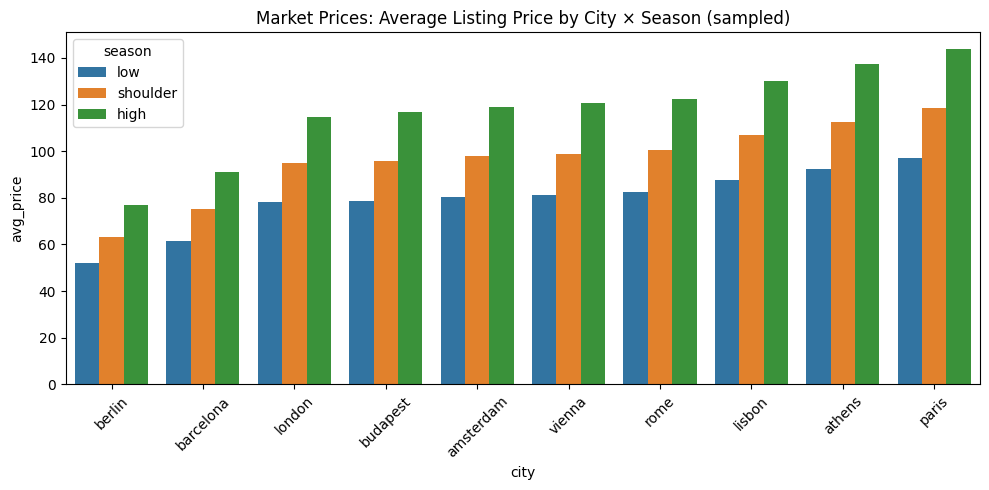

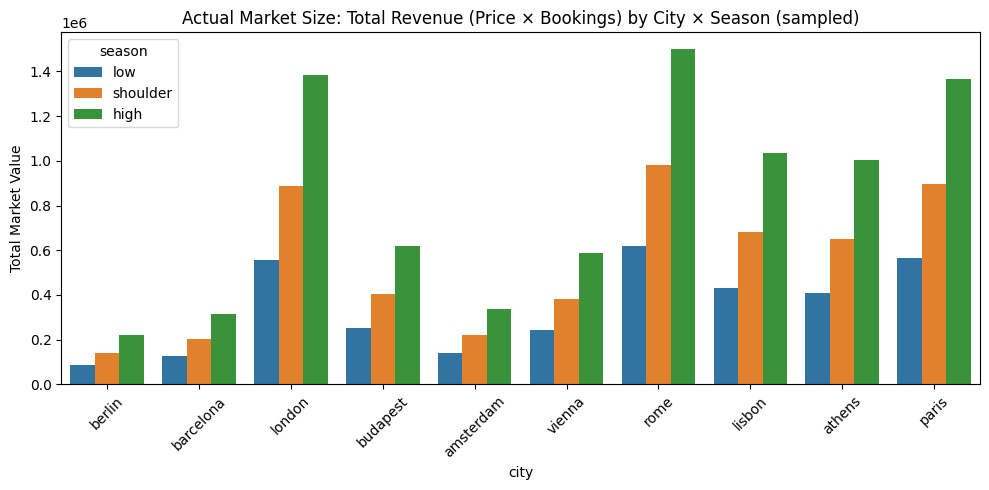

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns


# Use segment_df's pre-aggregated avg_price
city_day = (
    df.groupBy('city', 'season')
    .agg(F.avg('listing_price').alias('avg_price'))
    .orderBy(F.rand())
    .limit(20000)
    .orderBy('avg_price')
    .toPandas()
)

plt.figure(figsize=(10, 5))
sns.barplot(data=city_day, x='city', y='avg_price', hue='season', errorbar=None)
plt.title('Market Prices: Average Listing Price by City × Season (sampled)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'avg_price_by_city_season.png', dpi=150)
plt.show()

# Calculate actual market size (price × bookings) in Spark using the raw df (has 'listing_price' and 'occupancy_rate')
market_size = (
    df.groupBy('city', 'season')
    .agg(
        F.sum(F.col('listing_price') * F.col('occupancy_rate')).alias('total_market_value'),
        F.count('*').alias('listing_count'),
        F.avg(F.col('listing_price')).alias('avg_price')
    )
    .orderBy(F.rand())
    .limit(20000)
    .orderBy('avg_price')
    .toPandas()
)

plt.figure(figsize=(10, 5))
sns.barplot(data=market_size, x='city', y='total_market_value', hue='season', errorbar=None)
plt.title('Actual Market Size: Total Revenue (Price × Bookings) by City × Season (sampled)')
plt.ylabel('Total Market Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(project_root / 'outputs' / 'market_size_by_city_season.png', dpi=150)
plt.show()

In [54]:
# Remove unneeded columns before saving final dataset (Spark syntax)
cols_to_remove = ['capacity_bin', 'season', 'weekend', 'city', 'room_shared', 'room_private', 'log_bookings']

# Filter to only columns that exist
existing_cols = [col for col in cols_to_remove if col in listing_features_df.columns]

if existing_cols:
    listing_features_df = listing_features_df.drop(*existing_cols)
    print(f"Dropped columns: {existing_cols}")
else:
    print("No columns to drop.")

print(f"\nRemaining columns ({len(listing_features_df.columns)}):")
print(listing_features_df.columns)

Dropped columns: ['capacity_bin', 'season', 'weekend', 'city']

Remaining columns (53):
['listing_price', 'person_capacity', 'host_is_superhost', 'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'city_center_dist', 'metro_dist', 'listing_id', 'days_in_period', 'days_booked', 'occupancy_rate', 'log_price', 'price_per_person', 'price_per_bedroom', 'quality_score', 'price_x_satisfaction', 'price_per_dist_km', 'log_metro_dist', 'is_weekend', 'cat_room_type_entire_home_apt', 'cat_room_type_private_room', 'cat_room_type_shared_room', 'cat_city_amsterdam', 'cat_city_athens', 'cat_city_barcelona', 'cat_city_berlin', 'cat_city_budapest', 'cat_city_lisbon', 'cat_city_london', 'cat_city_paris', 'cat_city_rome', 'cat_city_vienna', 'cat_season_high', 'cat_season_low', 'cat_season_shoulder', 'cat_capacity_bin_2', 'cat_capacity_bin_3', 'cat_capacity_bin_4', 'cat_capacity_bin_5', 'segment_listing_count', 'segment_avg_price', 'segment_median_price', 'segment_p90_price', '

In [55]:
listing_features_df.count()

305252

In [56]:
# Save Spark outputs (native format, no toPandas)
listing_features_df.write.mode('overwrite').parquet(str(out_processed / 'listing_features.parquet'))
segment_df.write.mode('overwrite').parquet(str(out_processed / 'segment_demand_dataset.parquet'))

# Safe small preview only
preview_pdf = segment_df.limit(2000).toPandas()
preview_pdf.to_csv(outputs_dir / 'segment_dataset_preview.csv', index=False)